<a href="https://colab.research.google.com/github/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex/blob/main/DNN_low_pass_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------------------------------------------------------
# LSF information and object identification gain
-----------------------------------------------------------------------------
- Analysis of the position and category information contained in the early vlPFC response and the LSF component of images.

- Testing the hypothesis that this early information can serve as prior for better object identification
-----------------------------------------------------------------------------
## Private key
For the notebook to download the data from the Figshare repository prior to acceptance of the manuscript you need to insert the private link token mentioned in the "Code availability" section of the manuscript.

In [ ]:
private_link = input('Enter the private link token:')

# First, download data and import toolboxes

In [2]:
import os, re, pickle, warnings, time
from pathlib import Path
from itertools import combinations
import sys
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests
from pathlib import PurePath
from scipy.stats import gaussian_kde
import jax.numpy as jnp
from jax import jit
# Determine the path to the repository based on the environment
IN_COLAB = False
IN_KAGGLE = False # Assuming not in Kaggle for now
try:
    if 'google.colab' in str(get_ipython()):
        IN_COLAB = True
except NameError:
    pass

if IN_COLAB:
    path_to_repo = '/content/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
elif IN_KAGGLE:
    path_to_repo = '/kaggle/working/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
else:
    # Assume local environment where the .py file is in the root of the repo
    path_to_repo = '.'

# Only clone if not already present
if not os.path.exists(path_to_repo):
    os.system("git clone https://github.com/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex.git " + path_to_repo)

sys.path.append(path_to_repo)
sys.path.append(os.path.join(path_to_repo, 'utils'))

from extract_and_download_data import download_files, unzip
from image_processing import m_pathway_filter_gaussian

FIG_DIR = Path("Figures") # Convert to Path object
os.makedirs(FIG_DIR, exist_ok=True)
CACHE_DIR = Path(".cache");   CACHE_DIR.mkdir(exist_ok=True) # From Category decoding

# Define the directory where files are downloaded
DOWNLOAD_DIR = Path("downloads") # Convert to Path object
os.makedirs(DOWNLOAD_DIR, exist_ok=True)


# -------------------------------------------------------------------
# Download required data files once (using the new method)
files_to_download = [
    "hvm_public_extended_meta.csv",
    "deepNetFeatures.zip",
    "high_variation_stimuli.zip",
]
# Pass the correct path to file_code_mapping.csv to download_files
download_success = download_files(path_to_repo, files_to_download, private_link=private_link)

meta_downloaded_path = DOWNLOAD_DIR / "hvm_public_extended_meta.csv" # Use Path object
dnn_zip_downloaded_path = DOWNLOAD_DIR / "deepNetFeatures.zip" # Use Path object


meta_downloaded = meta_downloaded_path.exists()
dnn_zip_downloaded = dnn_zip_downloaded_path.exists()



if not (meta_downloaded and dnn_zip_downloaded):
    print("Failed to download necessary files. Exiting.")
    # exit() # Do not exit, just skip the parts that require these files

if dnn_zip_downloaded:
    # Update unzip to use the downloaded zip path and specify the extraction directory
    unzip(dnn_zip_downloaded_path, "deepNetFeatures")

Successfully downloaded downloads/hvm_public_extended_meta.csv.
Successfully downloaded downloads/high_variation_stimuli.zip.
Successfully downloaded downloads/deepNetFeatures.zip.


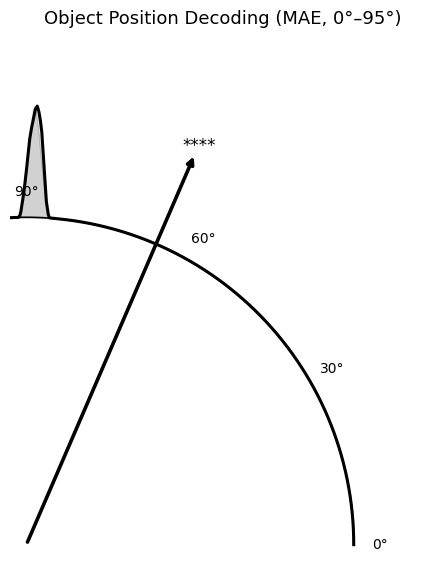

Figure saved → Figures/objpos_decoding_quartercircle_deg.png
                 Figures/objpos_decoding_quartercircle_deg.svg
                 Figures/objpos_decoding_quartercircle_deg.pdf


In [3]:
# -*- coding: utf-8 -*-
"""
DNN low-frequency (LSF) decoding
--------------------------------------------
Computes:
  1) Category pairwise decoding from low-pass DNN penultimate features.
     Saves:
       - Lowpass_probs.npy (per-trial mean correct class probability across pairs)
       - mean_predprob_per_trial_lowpass.npy (trial-wise mean of the above)
  2) Object position decoding from pooled low-pass DNNs (angle error per trial).
     Saves:
       - mean_pos_error_per_trial.npy
Assumes that required data already exist locally:
  - downloads/hvm_public_extended_meta.csv
  - deepNetFeatures/*_features_high_variation_lowpass.pkl
No neural data is needed in this script.
"""

import os, re, pickle
from pathlib import Path, PurePath
import numpy as np
import pandas as pd
from itertools import combinations
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --------------------- Paths ---------------------
DOWNLOAD_DIR = Path("downloads")
FEATURE_DIR  = Path("deepNetFeatures")
FIG_DIR      = Path("Figures"); FIG_DIR.mkdir(exist_ok=True, parents=True)

META_CSV = DOWNLOAD_DIR / "hvm_public_extended_meta.csv"

# --------------------- Utilities ---------------------
def load_and_align(pkl_path, meta_df):
    """Load penultimate activations from a features .pkl and align to the meta base order."""
    with open(pkl_path, "rb") as fh:
        d = pickle.load(fh)
    X = d["penultimate"]
    if X.ndim > 2:  # some models export H×W×C tensors at penultimate
        X = X.reshape(X.shape[0], -1)
    names = [Path(n).stem for n in d["image_names"]]
    idx = [names.index(b) for b in meta_df["base"]]
    return X[idx].astype(np.float64)

def decode_pair(cat1, cat2, X_flat, labels, obj_names):
    """
    Pairwise category decoding with leave‑one‑object‑per‑category‑out.
    Returns accuracy, p-value (binomial), and per-trial mean correct prob for this pair.
    """
    from scipy.stats import binomtest

    mask_pair  = (labels == cat1) | (labels == cat2)
    X_pair_all = X_flat[mask_pair]
    y_pair_all = (labels[mask_pair] == cat1).astype(int)
    obj_pair   = obj_names[mask_pair]

    # PCA fitted outside the pair to avoid leakage
    train_mask_for_pca = (labels != cat1) & (labels != cat2)
    pca_global = PCA(n_components=50, random_state=42).fit(X_flat[train_mask_for_pca])

    n_pair = len(X_pair_all)
    sum_pos  = np.zeros(n_pair, dtype=float)
    sum_corr = np.zeros(n_pair, dtype=float)
    counts   = np.zeros(n_pair, dtype=int)

    clf = LogisticRegression(max_iter=500, solver="lbfgs", random_state=42)

    objs1 = np.unique(obj_pair[y_pair_all == 1])
    objs0 = np.unique(obj_pair[y_pair_all == 0])
    for o1 in objs1:
        for o0 in objs0:
            te_mask = (obj_pair == o1) | (obj_pair == o0)
            tr_mask = ~te_mask
            if tr_mask.sum() == 0 or te_mask.sum() == 0:
                continue
            X_tr = pca_global.transform(X_pair_all[tr_mask])
            X_te = pca_global.transform(X_pair_all[te_mask])
            y_tr = y_pair_all[tr_mask]
            y_te = y_pair_all[te_mask]

            clf.fit(X_tr, y_tr)
            proba_pos = clf.predict_proba(X_te)[:, 1]
            proba_corr = np.where(y_te == 1, proba_pos, 1 - proba_pos)
            idx_te_within_pair = np.flatnonzero(te_mask)
            sum_corr[idx_te_within_pair] += proba_corr
            counts[idx_te_within_pair]   += 1

    valid = counts > 0
    mean_corr = np.full(n_pair, np.nan)
    if valid.any():
        mean_corr[valid] = sum_corr[valid] / counts[valid]
        preds = (mean_corr[valid] >= 0.5).astype(int)
        acc   = (preds == y_pair_all[valid]).mean()
        k     = int(acc * valid.sum())
        pval  = binomtest(k, n=valid.sum(), p=0.5, alternative="greater").pvalue
    else:
        acc = np.nan; pval = np.nan

    global_probs = np.full(len(labels), np.nan)
    global_probs[mask_pair] = mean_corr
    return (cat1, cat2, acc, pval, global_probs)

def parallel_decoding(X_flat, labels_cat, objects, cat_pairs):
    """Decode every category pair in parallel; return per-pair probabilities and trial means."""
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(decode_pair)(c1, c2, X_flat, labels_cat, objects) for c1, c2 in cat_pairs
    )
    probs= {(c1, c2): pr for c1, c2, _, _, pr in results}
    prob_matrix = np.stack([probs[pair] for pair in cat_pairs], axis=1)
    mean_trial  = np.nanmean(prob_matrix, axis=1)
    return prob_matrix, mean_trial

def predict_angles(pkl_path, meta_df, y_target, categories):
    """Category‑leave‑out regression of (cos,sin) → angle, returned in radians for all images."""
    X = load_and_align(pkl_path, meta_df)
    pred_t = np.zeros_like(y_target, dtype=np.float64)
    for cat in categories:
        tr = meta_df["category_name"] != cat
        te = ~tr
        pca = PCA(n_components=50, random_state=42)
        Xtr = pca.fit_transform(X[tr])
        Xte = pca.transform(X[te])
        reg = LinearRegression().fit(Xtr, y_target[tr])
        pred_t[te] = reg.predict(Xte)
    return np.arctan2(pred_t[:, 1], pred_t[:, 0])

def circ_diff(a, b):
    return np.arctan2(np.sin(a - b), np.cos(a - b))

def perm_pvalue(empirical, null_samples):
    if null_samples is None or len(null_samples) == 0 or np.isnan(empirical):
        return np.nan
    return (np.sum(null_samples <= empirical) + 1) / (len(null_samples) + 1)

def p_to_stars(p):
    if np.isnan(p):  return ''
    if p < 1e-4:     return '****'
    if p < 1e-3:     return '***'
    if p < 1e-2:     return '**'
    if p < 5e-2:     return '*'
    return ''

# ───────────────────────── Quarter‑circle drawing ─────────────────────────
THETA_MAX_DEG = 95   # extend slightly beyond 90° to include left KDE tail
THETA_MAX     = np.deg2rad(THETA_MAX_DEG)

def _deg_label(ax, R, deg):
    th = np.deg2rad(deg)
    ax.text(R*1.08*np.cos(th), R*1.08*np.sin(th), f'{deg}°',
            ha='center', va='center', fontsize=10, zorder=5)

def quartercircle_axes(ax, R=1.0, theta_max=THETA_MAX):
    """Draw only a quarter of a circle (0° → ~95°) with degree labels."""
    t = np.linspace(0, theta_max, 300)
    ax.plot(R*np.cos(t), R*np.sin(t), lw=1.2, color='black', zorder=7)

    # Degree labels around the arc
    for deg in (0, 30, 60, 90):
        _deg_label(ax, R, deg)

    # Neat framing for the first quadrant
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-R*0.05, R*1.25)
    ax.set_ylim(-R*0.05, R*1.55)
    ax.axis('off')

def draw_kde_bump(ax, samples, *,
                  R=1.0, height=0.35, n=400, color="black",
                  alpha_fill=0.22, lw=2.0, z=3, theta_max=THETA_MAX):
    """
    Draw a KDE "bump" outside the quarter arc.
    Samples are cropped to 1–99 percentiles to avoid extreme tails.
    Evaluated only on [0, theta_max] (default 95°).
    """
    samples = np.asarray(samples).ravel()
    if samples.size < 2 or not np.all(np.isfinite(samples)):
        return

    lo, hi = np.percentile(samples, [1, 99])
    samples = samples[(samples >= lo) & (samples <= hi)]
    if samples.size < 2:
        return

    try:
        kde = gaussian_kde(samples)
    except np.linalg.LinAlgError:
        if np.allclose(samples, samples[0]):
            theta = float(samples[0])
            theta = np.clip(theta, 0.0, theta_max)
            xb, yb = R*np.cos(theta), R*np.sin(theta)
            xd, yd = (R+height)*np.cos(theta), (R+height)*np.sin(theta)
            ax.plot([xb, xd], [yb, yd], color=color, lw=lw, zorder=z)
        return


    thetas = np.linspace(0.0, theta_max, n)  # evaluate only over the quarter
    dens = kde(thetas)
    if dens.max() == 0:
        return
    dens /= np.max(dens)

    f = height * dens
    xb, yb = R*np.cos(thetas),     R*np.sin(thetas)
    xd, yd = (R+f)*np.cos(thetas), (R+f)*np.sin(thetas)

    ax.fill_between(xb, yb, yd, color=color, alpha=alpha_fill, zorder=z)
    ax.plot(xd, yd, color=color, lw=lw, zorder=z+1)

# ───────────────────────── Config (unchanged) ─────────────────────────
plt.rcParams.update({"svg.fonttype": "none"})  # keep text editable in SVG
DNN_COLOR    = (0.0, 0.0, 0.0)                        # BLACK

FIG_DIR = Path(globals().get("FIG_DIR", "Figures")); FIG_DIR.mkdir(exist_ok=True)
meta_downloaded_path = globals().get("meta_downloaded_path", "downloads/hvm_public_extended_meta.csv")
dnn_zip_downloaded   = globals().get("dnn_zip_downloaded", True)

# ───────────────────────── Data prep (unchanged) ─────────────────────────
meta = pd.read_csv(META_CSV)
meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)

# keep only the 2,560 high-variation stimuli (skip first 640)
valid_idx = np.arange(640, len(meta))
meta = meta.iloc[valid_idx].reset_index(drop=True)

# centroid → polar angle (y, x)
pos = np.vstack((meta["centroid_y"].values, meta["centroid_x"].values)).T
pos = (pos - 128) / 256 * 8
true_angle = np.arctan2(pos[:, 1], pos[:, 0])  # note: (y, x) swap preserved
y_target = np.column_stack((np.cos(true_angle), np.sin(true_angle)))

categories   = meta["category_name"].unique()
cat_labels   = meta["category_name"].values
_cat_to_idx  = {c: np.flatnonzero(cat_labels == c) for c in categories}

# ───────────────────── Low‑pass DNN decoding (pooled) ─────────────────────
if dnn_zip_downloaded:
    feature_dir = Path("deepNetFeatures")
    p = re.compile(r"^(?P<net>.*?)_features_high_variation_lowpass\.pkl$")
    feat_files = [(m.group("net"), f) for f in feature_dir.glob("*.pkl") if (m := p.match(f.name))]

    if len(feat_files) == 0:
        print("No low-pass DNN feature files found.")
        perm_mae_dnn = np.array([]); mae_dnn = np.nan; err_per_trial = np.array([])
    else:
        pred_angles_all = Parallel(n_jobs=-1, backend="loky")(
            delayed(predict_angles)(f, meta, y_target, categories) # Removed 'n' from predict_angles call
            for n, f in feat_files
        )
        pred_angles_all = np.vstack(pred_angles_all)  # n_nets × n_trials
        avg_cos = np.cos(pred_angles_all).mean(axis=0)
        avg_sin = np.sin(pred_angles_all).mean(axis=0)
        avg_pred_angle = np.arctan2(avg_sin, avg_cos)

        err_per_trial = np.abs(circ_diff(avg_pred_angle, true_angle))
        np.save("mean_pos_error_per_trial.npy", err_per_trial)

        mae_dnn = err_per_trial.mean()

        N_PERM = 10_000 # Define N_PERM here as it's only needed for DNN now
        perm_mae_dnn = np.empty(N_PERM, dtype=np.float64)
        rng = np.random.default_rng(123)
        for i in range(N_PERM):
            shuffled = true_angle.copy()
            for _, idxs in _cat_to_idx.items():
                shuffled[idxs] = rng.permutation(shuffled[idxs])
            diff_p = circ_diff(avg_pred_angle, shuffled)
            perm_mae_dnn[i] = np.abs(diff_p).mean()
else:
    print("Skipping DNN decoding (zip not available).")
    perm_mae_dnn = np.array([]); mae_dnn = np.nan; err_per_trial = np.array([])

# ───────────────────── Stats ─────────────────────
p_dnn    = perm_pvalue(mae_dnn, perm_mae_dnn)

# ───────────────────── Plot (quarter‑circle up to 95°) ─────────────────────
fig, ax = plt.subplots(1, 1, figsize=(7.0, 5.6), constrained_layout=True)
quartercircle_axes(ax, R=1.0, theta_max=THETA_MAX)

# KDE bumps — DNN: black
draw_kde_bump(ax, perm_mae_dnn, R=1.0, height=0.34,
                color="black", alpha_fill=0.18, lw=2.2, z=3, theta_max=THETA_MAX)


# Observed MAE rays — clip angle to 95° so arrows stay inside the panel
eps = np.deg2rad(0.25)
thD = np.clip(mae_dnn, 0.0, THETA_MAX - eps)
ax.annotate("", xy=((1.0 + 0.30) * np.cos(thD), (1.0 + 0.30) * np.sin(thD)),
            xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=2.6, color=DNN_COLOR),
            zorder=6)
s = p_to_stars(p_dnn)
if s:
    ax.text((1.0 + 0.33) * np.cos(thD), (1.0 + 0.33) * np.sin(thD),
            s, ha='center', va='center', fontsize=12, color=DNN_COLOR, zorder=7)


ax.set_title("Object Position Decoding (MAE, 0°–95°)", pad=10, fontsize=13)

out_png = FIG_DIR / "objpos_decoding_quartercircle_deg.png"
out_svg = FIG_DIR / "objpos_decoding_quartercircle_deg.svg"
out_pdf = FIG_DIR / "objpos_decoding_quartercircle_deg.pdf"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
fig.savefig(out_svg, bbox_inches="tight")
fig.savefig(out_pdf, bbox_inches="tight")
plt.show()
print(f"Figure saved → {out_png}\n                 {out_svg}\n                 {out_pdf}")

# Category decoding




Pairwise category decoding — Low‑pass DNN …
   · decoding DeiT3_small_patch16_224_features_high_variation_lowpass.pkl
   · decoding CLIP_RN50_features_high_variation_lowpass.pkl
   · decoding DeiT_small_distilled_patch16_224_features_high_variation_lowpass.pkl
   · decoding ConvNeXt_base_in22ft1k_features_high_variation_lowpass.pkl
   · decoding CLIP_ViT-B_32_features_high_variation_lowpass.pkl
   · decoding ConvNeXt_tiny_in22ft1k_features_high_variation_lowpass.pkl
   · decoding EfficientNet_B0_features_high_variation_lowpass.pkl
   · decoding MobileNetV3_small_100_features_high_variation_lowpass.pkl
   · decoding ViT_B16_DINO_features_high_variation_lowpass.pkl
   · decoding ResNet50_features_high_variation_lowpass.pkl
   · decoding ResNet101_features_high_variation_lowpass.pkl
   · decoding Inception_v3_features_high_variation_lowpass.pkl
   · decoding OpenCLIP_ViT-B_32_laion2b_features_high_variation_lowpass.pkl
   · decoding OpenCLIP_ViT-B_32_openai_features_high_variation_lowpass

/tmp/ipython-input-1065101828.py:226: RuntimeWarning: invalid value encountered in divide
  mean_prob_dnn = np.where(cnt_prob > 0, sum_prob / cnt_prob, np.nan)


Saved:
  Figures/pairwise_combined_dnn_only.png
  Figures/pairwise_combined_dnn_only.svg
  Figures/pairwise_combined_dnn_only.pdf


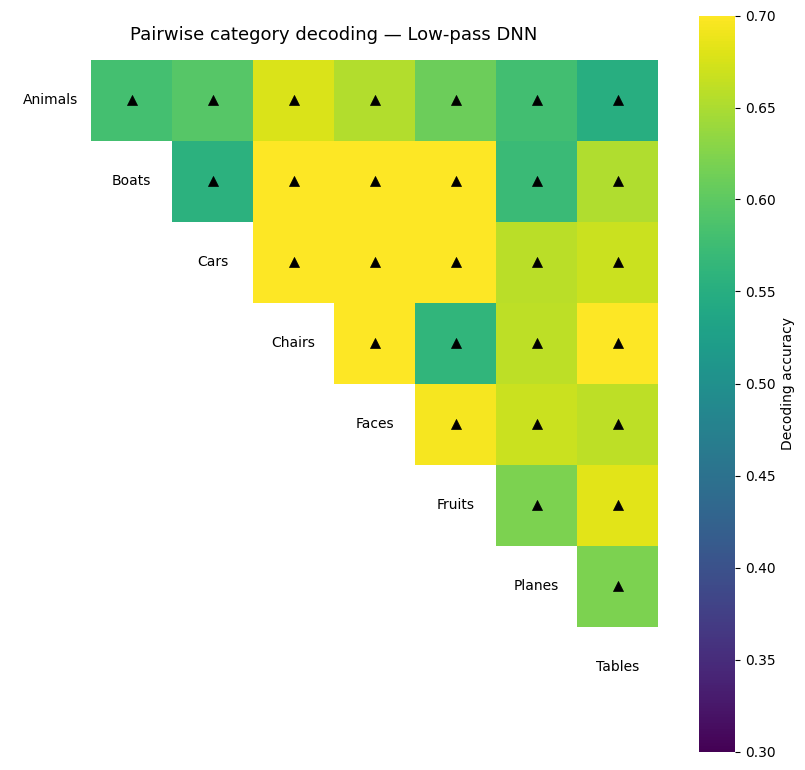

In [4]:
# ========================== Pairwise Category Decoding ========================
import re, os
from pathlib import Path, PurePath
from itertools import combinations
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# --- IO / Paths you already had somewhere above ---
# Expect these to be defined: meta_downloaded_path, even_downloaded_path, odd_downloaded_path
FIG_DIR = Path("Figures"); FIG_DIR.mkdir(exist_ok=True, parents=True)

# ---------- Load & filter metadata ----------
meta = pd.read_csv(meta_downloaded_path)
meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)
valid_idx = np.arange(640, len(meta))
meta = meta.iloc[valid_idx].reset_index(drop=True)

# ---------- Helpers ----------
def flatten(data, t_idx):
    data = data[:, :, t_idx]
    return data.reshape(data.shape[0], -1)

def decode_pair(cat1, cat2, X_flat, labels, obj_names):
    """
    Pairwise decoding with leave‑one‑object‑per‑category out.
    Aggregates per‑trial probabilities across all (o1,o0) test folds.
    """
    mask_pair  = (labels == cat1) | (labels == cat2)
    X_pair_all = X_flat[mask_pair]
    y_pair_all = (labels[mask_pair] == cat1).astype(int)
    obj_pair   = obj_names[mask_pair]

    # PCA fitted outside pair images to avoid leakage
    train_mask_for_pca = (labels != cat1) & (labels != cat2)
    pca_global = PCA(n_components=50, random_state=42).fit(X_flat[train_mask_for_pca])

    n_pair = len(X_pair_all)
    sum_pos  = np.zeros(n_pair, dtype=float)
    sum_corr = np.zeros(n_pair, dtype=float)
    counts   = np.zeros(n_pair, dtype=int)

    objs1 = np.unique(obj_pair[y_pair_all == 1])
    objs0 = np.unique(obj_pair[y_pair_all == 0])

    clf = LogisticRegression(max_iter=500, solver="lbfgs", random_state=42)

    for o1 in objs1:
        for o0 in objs0:
            te_mask = (obj_pair == o1) | (obj_pair == o0)
            tr_mask = ~te_mask
            if tr_mask.sum() == 0 or te_mask.sum() == 0:
                continue

            X_tr = pca_global.transform(X_pair_all[tr_mask])
            X_te = pca_global.transform(X_pair_all[te_mask])
            y_tr = y_pair_all[tr_mask]
            y_te = y_pair_all[te_mask]

            clf.fit(X_tr, y_tr)
            proba_pos = clf.predict_proba(X_te)[:, 1]  # P(class==cat1)
            proba_corr = np.where(y_te == 1, proba_pos, 1 - proba_pos)

            idx_te_within_pair = np.flatnonzero(te_mask)
            sum_pos[idx_te_within_pair]  += proba_pos
            sum_corr[idx_te_within_pair] += proba_corr
            counts[idx_te_within_pair]   += 1

    valid = counts > 0
    if valid.sum() == 0:
        global_probs = np.full(len(labels), np.nan)
        global_probs[mask_pair] = np.nan
        return (cat1, cat2, np.nan, np.nan, global_probs)

    mean_pos  = np.full(n_pair, np.nan);  mean_pos[valid]  = sum_pos[valid] / counts[valid]
    mean_corr = np.full(n_pair, np.nan);  mean_corr[valid] = sum_corr[valid] / counts[valid]

    preds = (mean_pos[valid] >= 0.5).astype(int)
    acc   = (preds == y_pair_all[valid]).mean()
    k     = int(acc * valid.sum())
    pval  = binomtest(k, n=valid.sum(), p=0.5, alternative="greater").pvalue

    global_probs = np.full(len(labels), np.nan)
    global_probs[mask_pair] = mean_corr
    return (cat1, cat2, acc, pval, global_probs)

def parallel_decoding(X_flat, labels_cat, objects, cat_pairs):
    """Decode every category pair in parallel; return matrices and per-trial means."""
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(decode_pair)(c1, c2, X_flat, labels_cat, objects)
        for c1, c2 in cat_pairs
    )

    acc  = {(c1, c2): a for c1, c2, a, _, _ in results}
    pval = {(c1, c2): p for c1, c2, _, p, _ in results}
    probs= {(c1, c2): pr for c1, c2, _, _, pr in results}

    prob_matrix = np.stack([probs[pair] for pair in cat_pairs], axis=1)
    mean_trial  = np.nanmean(prob_matrix, axis=1)

    # FDR over all pairs
    p_vals = np.array([pval[pair] for pair in cat_pairs])
    _, q, _, _ = multipletests(p_vals, method="fdr_bh")
    qdict = {pair: qv for pair, qv in zip(cat_pairs, q)}

    categories = np.unique(labels_cat)
    nC = len(categories)
    A  = np.full((nC, nC), np.nan)
    S  = np.zeros((nC, nC), bool)
    for (c1, c2) in cat_pairs:
        i = np.where(categories == c1)[0][0]
        j = np.where(categories == c2)[0][0]
        if i < j:
            A[i, j] = acc[(c1, c2)]
            S[i, j] = qdict[(c1, c2)] < 0.05
    return A, S, probs, mean_trial

def category_confusion_matrix(A_dnn, S_dnn, categories,
                                         vmin=.3, vmax=.7, cmap="viridis"):
    """
    Build one matrix where:
      - Upper triangle (i<j): DNN accuracies and significance markers
      - Lower triangle (i>j): white (empty)
      - Diagonal: blank (with category names written inside)
    Significance:
      - DNN   : filled triangle '▲' on upper cells with q<.05
    """
    nC = len(categories)
    C   = np.full((nC, nC), np.nan)
    SigD= np.zeros((nC, nC), bool)

    # Upper: DNN (already stored on upper in A_dnn)
    if A_dnn is not None:
        upper = ~np.isnan(A_dnn)
        C[upper] = A_dnn[upper]
        SigD[upper] = S_dnn[upper]

    # Heatmap without ticks; diagonal left NaN for text overlay
    fig, ax = plt.subplots(figsize=(8.4, 7.8))
    mask = np.isnan(C)
    hm = sns.heatmap(C, vmin=vmin, vmax=vmax, cmap=cmap, mask=mask,
                     cbar=True, square=True, ax=ax,
                     xticklabels=False, yticklabels=False,
                     cbar_kws={"label": "Decoding accuracy"})

    # Diagonal category names
    for i, cat in enumerate(categories):
        ax.text(i + 0.5, i + 0.5, str(cat),
                ha="center", va="center", fontsize=10,
                color="black", rotation=0)

    # Significance overlays
    # DNN (upper): filled triangles
    for i in range(nC):
        for j in range(i + 1, nC):
            if SigD[i, j]:
                ax.scatter(j + 0.5, i + 0.5, s=52, marker="^",
                           facecolors="black", edgecolors="black", linewidths=0.5)

    # Borders and labels
    ax.set_title("Pairwise category decoding — Low‑pass DNN",
                 pad=14, fontsize=13)

    # Custom legend
    from matplotlib.lines import Line2D
    legend_elems = [
        Line2D([0], [0], marker='^', linestyle='None', markersize=7,
               markerfacecolor='black', markeredgecolor='black', label='DNN q<.05'),
    ]
    plt.tight_layout()
    out_svg = FIG_DIR / "pairwise_combined_dnn_only.svg"
    out_png = FIG_DIR / "pairwise_combined_dnn_only.png"
    out_pdf = FIG_DIR / "pairwise_combined_dnn_only.pdf"
    fig.savefig(out_svg); fig.savefig(out_png, dpi=300); fig.savefig(out_pdf)
    print(f"Saved:\n  {out_png}\n  {out_svg}\n  {out_pdf}")
    plt.show()

# ------------------------------ Run pairwise decoding -------------------------
meta_df = meta.copy()
labels_cat = meta_df["category_name"].values
objects    = meta_df["object_name"].values
categories_unique = np.unique(labels_cat)
cat_pairs  = list(combinations(categories_unique, 2))

A_dnn = Sig_dnn = None

# Low‑pass DNN features (pooled across nets if present)
feature_dir = Path("deepNetFeatures")
if feature_dir.exists():
    print("Pairwise category decoding — Low‑pass DNN …")
    PKL_RE = re.compile(r"^(?P<net>.*?)_features_high_variation_lowpass\.pkl$")
    lowpass_pkls = [p for p in feature_dir.glob("*.pkl") if PKL_RE.match(p.name)]
    if not lowpass_pkls:
        print(f"No low‑pass DNN feature files found in {feature_dir}.")
    else:
        def process_net(pkl_path, meta_df):
            with open(pkl_path, "rb") as fh:
                feats = np.load(fh, allow_pickle=True)
            img_names = [PurePath(p).stem for p in feats["image_names"]]
            base = meta_df["filename"].str.replace(r"\.\w+$", "", regex=True)
            idx = np.array([img_names.index(b) for b in base])
            X = feats["penultimate"][idx]
            if X.ndim > 2:
                X = X.reshape(X.shape[0], -1)
            return X

        n_trials = len(labels_cat)
        sum_prob = np.zeros((n_trials, len(cat_pairs)), dtype=float)
        cnt_prob = np.zeros((n_trials, len(cat_pairs)), dtype=int)

        for pkl in lowpass_pkls:
            print(f"   · decoding {pkl.name}")
            X_net = process_net(pkl, meta_df)
            A_tmp, S_tmp, probs_net, _ = parallel_decoding(X_net, labels_cat, objects, cat_pairs)
            prob_matrix = np.stack([probs_net[pair] for pair in cat_pairs], axis=1)
            valid = ~np.isnan(prob_matrix)
            sum_prob[valid] += prob_matrix[valid]
            cnt_prob[valid] += 1

        mean_prob_dnn = np.where(cnt_prob > 0, sum_prob / cnt_prob, np.nan)
        np.save("Lowpass_probs.npy", mean_prob_dnn)
        np.save("mean_predprob_per_trial_lowpass.npy", np.nanmean(mean_prob_dnn, axis=1))

        # Build accuracy+significance matrices from pooled probs (upper only, mirror later)
        A_dnn     = np.full((len(categories_unique), len(categories_unique)), np.nan)
        Sig_dnn   = np.zeros_like(A_dnn, dtype=bool)
        pair_p    = []
        pair_idx  = []

        for col, (c1, c2) in enumerate(cat_pairs):
            rows = np.where((labels_cat == c1) | (labels_cat == c2))[0]
            pvec = mean_prob_dnn[rows, col]
            ok   = ~np.isnan(pvec)
            n    = ok.sum()
            if n == 0:
                pair_p.append(1.0); pair_idx.append((c1, c2))
                continue
            k = int((pvec[ok] >= 0.5).sum())
            pair_p.append(binomtest(k, n=n, p=0.5, alternative="greater").pvalue)
            pair_idx.append((c1, c2))
            i = np.where(categories_unique == c1)[0][0]
            j = np.where(categories_unique == c2)[0][0]
            if i < j:
                A_dnn[i, j] = k / n

        _, qvals, _, _ = multipletests(np.array(pair_p), method="fdr_bh")
        for (c1, c2), qv in zip(pair_idx, qvals):
            i = np.where(categories_unique == c1)[0][0]
            j = np.where(categories_unique == c2)[0][0]
            if i < j and qv < 0.05:
                Sig_dnn[i, j] = True
else:
    print("Skipping DNN pairwise decoding (deepNetFeatures folder not found).")


# Call the renamed plotting function
category_confusion_matrix(A_dnn, Sig_dnn, categories_unique)

# Download predictive probabilities and position prediction

In [5]:
from google.colab import files

files_to_download = [
    "Lowpass_probs.npy",
    "mean_predprob_per_trial_lowpass.npy",
    "mean_pos_error_per_trial.npy",
]

for file_name in files_to_download:
    if os.path.exists(file_name):
        files.download(file_name)
        print(f"Downloaded {file_name}")
    else:
        print(f"{file_name} not found, skipping download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded Lowpass_probs.npy


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded mean_predprob_per_trial_lowpass.npy


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded mean_pos_error_per_trial.npy
